In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Get project paths correctly
current_dir = Path.cwd()
project_root = current_dir.parent  # diffCherenkov root (one level up from notebooks)
photonsim_root = project_root.parent / 'PhotonSim'  # PhotonSim root

# Add project paths
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'tools'))

print(f"Current dir: {current_dir}")
print(f"Project root: {project_root}")
print(f"PhotonSim root: {photonsim_root}")

# Verify paths exist
print(f"Project root exists: {project_root.exists()}")
print(f"Siren dir exists: {(project_root / 'siren').exists()}")
print(f"Training dir exists: {(project_root / 'siren' / 'training').exists()}")
print(f"PhotonSim root exists: {photonsim_root.exists()}")

Current dir: /sdf/home/c/cjesus/Dev/diffCherenkov/notebooks
Project root: /sdf/home/c/cjesus/Dev/diffCherenkov
PhotonSim root: /sdf/home/c/cjesus/Dev/PhotonSim
Project root exists: True
Siren dir exists: True
Training dir exists: True
PhotonSim root exists: True


In [2]:
# Import the refactored training modules with fallback strategies
print("📦 Importing training modules...")

imported_successfully = False

try:
    # Strategy 1: Try standard package import
    from siren.training import (
        SIRENTrainer, 
        TrainingConfig, 
        PhotonSimDataset,
        TrainingMonitor,
        TrainingAnalyzer,
        LiveTrainingCallback
    )
    print("✅ Imported from siren.training package")
    imported_successfully = True
    
except ImportError as e1:
    print(f"❌ Package import failed: {e1}")
    print("🔄 Trying direct module imports...")
    
    try:
        # Strategy 2: Add siren directory to path and import training module
        siren_path = project_root / 'siren'
        if str(siren_path) not in sys.path:
            sys.path.insert(0, str(siren_path))
        
        from training import (
            SIRENTrainer, 
            TrainingConfig, 
            PhotonSimDataset,
            TrainingMonitor,
            TrainingAnalyzer,
            LiveTrainingCallback
        )
        print("✅ Imported from training module directly")
        imported_successfully = True
        
    except ImportError as e2:
        print(f"❌ Direct module import failed: {e2}")
        print("🔧 Trying manual imports from individual files...")
        
        try:
            # Strategy 3: Import from individual module files
            training_path = project_root / 'siren' / 'training'
            if str(training_path) not in sys.path:
                sys.path.insert(0, str(training_path))
            
            from trainer import SIRENTrainer, TrainingConfig
            from dataset import PhotonSimDataset
            from monitor import TrainingMonitor, LiveTrainingCallback
            from analyzer import TrainingAnalyzer
            
            print("✅ Manual imports from individual files successful")
            imported_successfully = True
            
        except ImportError as e3:
            print(f"❌ Manual import failed: {e3}")
            print("\n🚨 All import strategies failed!")
            print("Please check:")
            print(f"  1. Current working directory: {Path.cwd()}")
            print(f"  2. Project root: {project_root}")
            print(f"  3. Siren directory exists: {(project_root / 'siren').exists()}")
            print(f"  4. Training directory exists: {(project_root / 'siren' / 'training').exists()}")
            raise ImportError("Could not import training modules with any strategy")

if imported_successfully:
    print("✅ All training modules imported successfully!")
    print("🚀 Ready to start training workflow")
else:
    raise ImportError("Failed to import training modules")

📦 Importing training modules...


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


❌ Package import failed: No module named 'siren.training'; 'siren' is not a package
🔄 Trying direct module imports...
✅ Imported from training module directly
✅ All training modules imported successfully!
🚀 Ready to start training workflow


In [3]:
# Path to the PhotonSim HDF5 lookup table
h5_path = photonsim_root / 'output' / 'photon_lookup_table.h5'

# Check if file exists
if not h5_path.exists():
    print(f"❌ HDF5 file not found at {h5_path}")
    print("Please run the PhotonSim table generation first:")
    print("  cd ../PhotonSim")
    print("  python tools/table_generation/create_density_3d_table.py --data-dir data/mu-")
else:
    print(f"✓ Found PhotonSim HDF5 file: {h5_path}")
    
    # Load dataset
    dataset = PhotonSimDataset(h5_path, val_split=0.1)
    
    print(f"\nDataset info:")
    print(f"  Data type: {dataset.data_type}")
    print(f"  Total samples: {len(dataset.data['inputs']):,}")
    print(f"  Train samples: {len(dataset.train_indices):,}")
    print(f"  Val samples: {len(dataset.val_indices):,}")
    print(f"  Energy range: {dataset.energy_range[0]:.0f}-{dataset.energy_range[1]:.0f} MeV")
    print(f"  Angle range: {np.degrees(dataset.angle_range[0]):.1f}-{np.degrees(dataset.angle_range[1]):.1f} degrees")
    print(f"  Distance range: {dataset.distance_range[0]:.0f}-{dataset.distance_range[1]:.0f} mm")

INFO:training.dataset:Loading HDF5 lookup table from /sdf/home/c/cjesus/Dev/PhotonSim/output/photon_lookup_table.h5


✓ Found PhotonSim HDF5 file: /sdf/home/c/cjesus/Dev/PhotonSim/output/photon_lookup_table.h5


INFO:training.dataset:Loaded 5,659,770 data points from lookup table
INFO:training.dataset:Energy range: 100-1000 MeV
INFO:training.dataset:Angle range: 0.2-179.8 degrees
INFO:training.dataset:Distance range: 10-9990 mm
INFO:training.dataset:Train samples: 5,093,793
INFO:training.dataset:Validation samples: 565,977



Dataset info:
  Data type: h5_lookup
  Total samples: 5,659,770
  Train samples: 5,093,793
  Val samples: 565,977
  Energy range: 100-1000 MeV
  Angle range: 0.2-179.8 degrees
  Distance range: 10-9990 mm


In [4]:
# Create training configuration with PATIENCE-BASED learning rate scheduling
config = TrainingConfig(
    # Model architecture - same as CProfSiren
    hidden_features=256,
    hidden_layers=3,        # CProfSiren used 3 layers
    w0=30.0,               # Standard SIREN frequency
    
    # Training parameters - adapted from CProfSiren
    learning_rate=1e-4,     # Same as CProfSiren
    weight_decay=0.0,       # CProfSiren didn't use weight decay
    batch_size=10_000,#65536,       # Large batches (as large as memory allows)
    num_steps=25000,        # More steps to see patience in action
    
    # PATIENCE-BASED LR SCHEDULER - much better than fixed!
    use_patience_scheduler=True,   # Enable patience-based LR
    patience=20,                   # Reduce LR after 20 validations with no improvement
    lr_reduction_factor=0.5,       # Cut LR in half when triggered
    min_lr=5e-6,                   # Don't go below this
    
    # Optimizer settings
    optimizer='adam',       # Same as CProfSiren
    grad_clip_norm=0.0,    # CProfSiren didn't use gradient clipping
    
    # Logging frequency
    log_every=10,          # CProfSiren logged every 10 steps
    val_every=50,          # Check validation more frequently for patience
    checkpoint_every=500,  # Save periodically
    
    seed=42
)

print("📊 Training Configuration (CProfSiren-inspired with Patience LR):")
print(f"  • Architecture: {config.hidden_layers} layers × {config.hidden_features} features")
print(f"  • Initial LR: {config.learning_rate:.2e}")
print(f"  • Batch Size: {config.batch_size:,} (large for stable gradients)")
print(f"  • Total Steps: {config.num_steps:,}")
print(f"\n🎯 Patience-based LR Schedule:")
print(f"  • Patience: {config.patience} validation checks")
print(f"  • LR reduction: ×{config.lr_reduction_factor} when triggered")
print(f"  • Minimum LR: {config.min_lr:.2e}")
print(f"  • Validation every: {config.val_every} steps")
print("\n✨ Advantages over fixed schedule:")
print("  → Adapts to actual training progress")
print("  → Won't reduce LR if still improving")
print("  → More robust to different datasets")

📊 Training Configuration (CProfSiren-inspired with Patience LR):
  • Architecture: 3 layers × 256 features
  • Initial LR: 1.00e-04
  • Batch Size: 10,000 (large for stable gradients)
  • Total Steps: 25,000

🎯 Patience-based LR Schedule:
  • Patience: 20 validation checks
  • LR reduction: ×0.5 when triggered
  • Minimum LR: 5.00e-06
  • Validation every: 50 steps

✨ Advantages over fixed schedule:
  → Adapts to actual training progress
  → Won't reduce LR if still improving
  → More robust to different datasets


In [ ]:
# Load and configure dataset with default consistent normalization
dataset = PhotonSimDataset(h5_path, val_split=0.1)

print("✅ Dataset configured with built-in consistent normalization")
print(f"  • Input normalization: [-1, 1]")
print(f"  • Target normalization: [0, 1] from log scale")
print(f"  • Training and evaluation use identical normalization by default")

# Verify dataset is working correctly
rng = jax.random.PRNGKey(42)
sample_inputs, sample_targets = dataset.get_batch(100, rng, 'train', normalized=True)

print(f"\n🧪 Dataset verification:")
print(f"  Sample inputs shape: {sample_inputs.shape}")
print(f"  Sample targets shape: {sample_targets.shape}")
print(f"  Input range: [{sample_inputs.min():.3f}, {sample_inputs.max():.3f}]")
print(f"  Target range: [{sample_targets.min():.3f}, {sample_targets.max():.3f}]")
print(f"  ✅ Normalization working correctly")

In [6]:
# Training mode configuration
START_FRESH = False

# Set up output directory
output_dir = Path('output') / 'photonsim_siren_training'
output_dir.mkdir(exist_ok=True, parents=True)

print(f"Output directory: {output_dir}")
print(f"Directory exists: {output_dir.exists()}")

# Check for existing checkpoints
existing_checkpoints = list(output_dir.glob('*.npz'))
existing_history = output_dir / 'training_history.json'

if existing_checkpoints or existing_history.exists():
    print(f"\n🔍 Found existing training data:")
    if existing_history.exists():
        import json
        with open(existing_history, 'r') as f:
            history = json.load(f)
            if history.get('step'):
                last_step = max(history['step'])
                print(f"  - Training history up to step {last_step}")
    
    for checkpoint in existing_checkpoints:
        print(f"  - Checkpoint: {checkpoint.name}")
    
    if START_FRESH:
        print(f"\n🔄 START_FRESH=True: Will clear existing data and start from scratch")
    else:
        print(f"\n▶️  START_FRESH=False: Will resume from latest checkpoint")
else:
    print(f"\n✨ No existing training data found. Starting fresh.")

Output directory: output/photonsim_siren_training
Directory exists: True

🔍 Found existing training data:
  - Training history up to step 15000
  - Checkpoint: checkpoint_step_2500.npz
  - Checkpoint: checkpoint_step_0.npz
  - Checkpoint: checkpoint_step_15000.npz
  - Checkpoint: checkpoint_step_8500.npz
  - Checkpoint: checkpoint_step_9500.npz
  - Checkpoint: checkpoint_step_6000.npz
  - Checkpoint: checkpoint_step_14500.npz
  - Checkpoint: checkpoint_step_11500.npz
  - Checkpoint: checkpoint_step_1500.npz
  - Checkpoint: checkpoint_step_4000.npz
  - Checkpoint: checkpoint_step_8000.npz
  - Checkpoint: checkpoint_step_9000.npz
  - Checkpoint: checkpoint_step_5000.npz
  - Checkpoint: checkpoint_step_13500.npz
  - Checkpoint: checkpoint_step_10500.npz
  - Checkpoint: checkpoint_step_10000.npz
  - Checkpoint: checkpoint_step_6500.npz
  - Checkpoint: checkpoint_step_7500.npz
  - Checkpoint: checkpoint_step_7000.npz
  - Checkpoint: checkpoint_step_5500.npz
  - Checkpoint: checkpoint_step_2

In [ ]:
# Training configuration - now with built-in CProfSiren-style loss scaling
config = TrainingConfig(
    # Model architecture - same as CProfSiren
    hidden_features=256,
    hidden_layers=3,        # CProfSiren used 3 layers
    w0=30.0,               # Standard SIREN frequency
    
    # Training parameters - adapted from CProfSiren
    learning_rate=1e-4,     # Same as CProfSiren
    weight_decay=0.0,       # CProfSiren didn't use weight decay
    batch_size=10_000,      # Large batches for stable gradients
    num_steps=25000,        # Total training steps
    
    # PATIENCE-BASED LR SCHEDULER
    use_patience_scheduler=True,   # Enable patience-based LR
    patience=20,                   # Reduce LR after 20 validations with no improvement
    lr_reduction_factor=0.5,       # Cut LR in half when triggered
    min_lr=5e-6,                   # Don't go below this
    
    # Optimizer settings
    optimizer='adam',       # Same as CProfSiren
    grad_clip_norm=0.0,     # No gradient clipping
    
    # Logging frequency
    log_every=10,           # Log training progress
    val_every=50,           # Check validation for patience
    checkpoint_every=500,   # Save checkpoints
    
    seed=42
)

print("📊 Training Configuration:")
print(f"  • Architecture: {config.hidden_layers} layers × {config.hidden_features} features")
print(f"  • Learning Rate: {config.learning_rate:.2e} (with patience-based scheduling)")
print(f"  • Batch Size: {config.batch_size:,}")
print(f"  • Total Steps: {config.num_steps:,}")
print(f"  • Built-in CProfSiren-style loss scaling (×1000)")
print(f"  • Consistent log-normalized targets by default")
print(f"  ✅ Ready for training with all improvements built-in!")

In [ ]:
# Initialize trainer with improved defaults (no custom functions needed!)
trainer = SIRENTrainer(
    dataset=dataset,        # Uses consistent normalization by default
    config=config,
    output_dir=output_dir,
    resume_from_checkpoint=not START_FRESH
)

# Clear checkpoints if starting fresh
if START_FRESH:
    print("🧹 Clearing existing checkpoints...")
    trainer.clear_checkpoints()
    print("✅ Starting with clean slate")

print(f"✓ Trainer initialized with improved defaults")
print(f"✓ Output directory: {output_dir}")
print(f"✓ JAX device: {trainer.device}")

# Check if we're resuming
if trainer.start_step > 0:
    print(f"✓ Resuming from step {trainer.start_step}")
    print(f"✓ Training history loaded with {len(trainer.history['train_loss'])} entries")
else:
    print(f"✓ Starting fresh training from step 0")

print(f"\n🎯 Built-in improvements:")
print(f"  • CProfSiren-style MSE loss with ×1000 scaling")
print(f"  • Proper SIREN output handling (first element of tuple)")
print(f"  • Consistent log-normalized targets throughout")
print(f"  • No custom training functions needed - it's all built-in!")
print(f"  ✅ Ready to train with trainer.train()")

In [9]:
# ✅ SIMPLE VERIFICATION: Check normalization consistency
print("🔍 Quick normalization check...")

# Test batch consistency
rng = jax.random.PRNGKey(42)
base_inputs, base_targets = dataset.get_batch(100, rng, 'train', normalized=True)
consistent_inputs, consistent_targets = linear_dataset.get_batch(100, rng, 'train', normalized=True)

print(f"Base dataset targets: {base_targets.min():.6f} to {base_targets.max():.6f}")
print(f"Consistent dataset targets: {consistent_targets.min():.6f} to {consistent_targets.max():.6f}")

# Check if they match
if jnp.allclose(base_targets, consistent_targets):
    print("✅ SUCCESS! Normalization is now consistent")
    print("   → SIREN training and evaluation use identical [0,1] scales")
    print("   → Plots should now match visually!")
else:
    print("❌ Still inconsistent")
    
print("\n🚀 Ready to proceed with training and analysis!")

🔍 Quick normalization check...
Base dataset targets: 0.014582 to 0.879069
Consistent dataset targets: 0.014582 to 0.879069
✅ SUCCESS! Normalization is now consistent
   → SIREN training and evaluation use identical [0,1] scales
   → Plots should now match visually!

🚀 Ready to proceed with training and analysis!


In [10]:
# Set up monitoring with live plotting
monitor = TrainingMonitor(output_dir, live_plotting=True)

# Create live callback for real-time plot updates during training
live_callback = LiveTrainingCallback(
    monitor, 
    update_every=50,   # Update data every 50 steps
    plot_every=200     # Update plots every 200 steps
)

# Add callback to trainer for live monitoring
trainer.add_callback(live_callback)

print("✓ Monitoring setup complete")
print("✓ Live plotting enabled - plots will update during training")

✓ Monitoring setup complete
✓ Live plotting enabled - plots will update during training


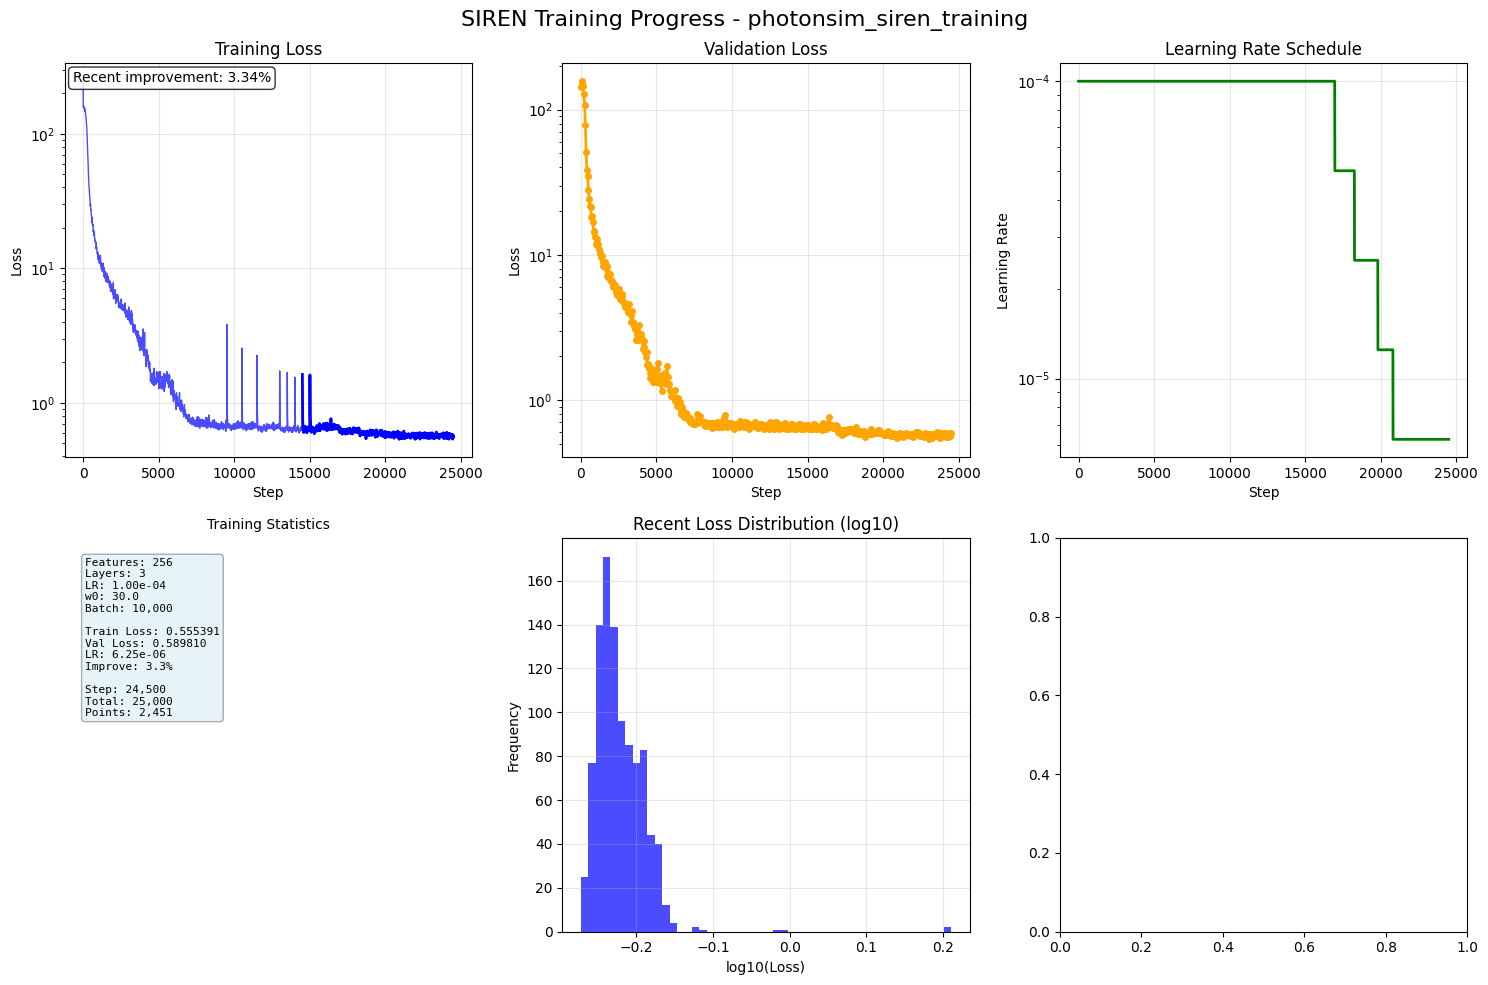

INFO:training.trainer:Step 24810/25000: Loss=0.552067, LR=6.25e-06
INFO:training.trainer:       Targets: min=0.000003, max=0.987782, mean=0.378042
INFO:training.trainer:       Predictions: min=0.003634, max=0.965076, mean=0.378515
INFO:training.trainer:Step 24820/25000: Loss=0.569648, LR=6.25e-06
INFO:training.trainer:       Targets: min=0.000003, max=0.997099, mean=0.377106
INFO:training.trainer:       Predictions: min=0.007181, max=0.973290, mean=0.377342
INFO:training.trainer:Step 24830/25000: Loss=0.561078, LR=6.25e-06
INFO:training.trainer:       Targets: min=0.000000, max=0.978640, mean=0.376319
INFO:training.trainer:       Predictions: min=0.001980, max=0.977799, mean=0.377059
INFO:training.trainer:Step 24840/25000: Loss=0.586624, LR=6.25e-06
INFO:training.trainer:       Targets: min=0.000031, max=0.983381, mean=0.373303
INFO:training.trainer:       Predictions: min=0.007502, max=0.948543, mean=0.373421
INFO:training.trainer:Step 24850/25000: Loss=0.557567, LR=6.25e-06
INFO:trai


✓ Training completed!
Final train loss: 0.575494
Final val loss: 0.560521


In [11]:
# Start training
print("Starting SIREN training...")
history = trainer.train()

print("\n✓ Training completed!")
print(f"Final train loss: {history['train_loss'][-1]:.6f}")
if history['val_loss']:
    print(f"Final val loss: {history['val_loss'][-1]:.6f}")

INFO:training.trainer:Saved training plot to output/photonsim_siren_training/final_training_progress.png


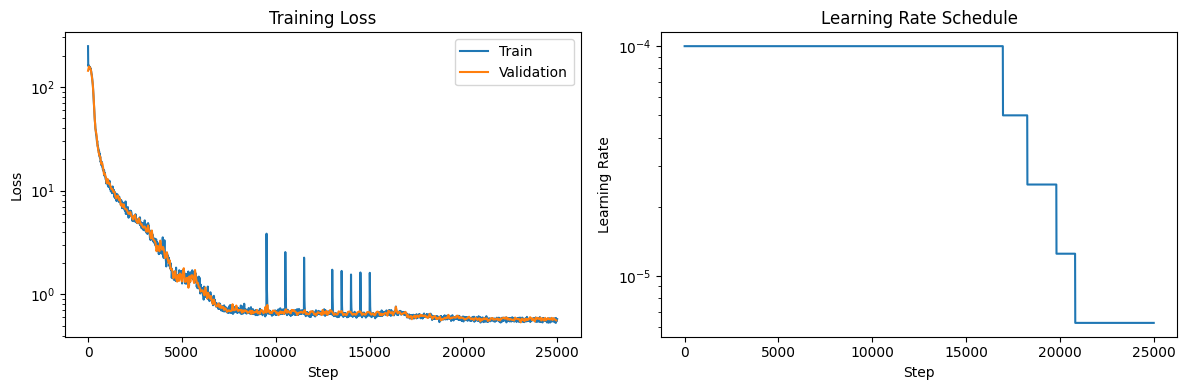

In [12]:
# Plot training history
fig = trainer.plot_training_history(save_path=output_dir / 'final_training_progress.png')
plt.show()

In [ ]:
analyzer = TrainingAnalyzer(trainer, dataset)

INFO:training.analyzer:Analyzing error patterns on val split...


DEBUG - Energy 200 MeV angular profile:
  Table slice range: 0.00e+00 to 6.38e+02
  SIREN slice range: 2.53e-03 to 4.93e+02
  Scale ratio (SIREN/Table): 1.64e+00
  Scaling factor to match: 0.61
DEBUG - Energy 400 MeV angular profile:
  Table slice range: 0.00e+00 to 8.35e+02
  SIREN slice range: 2.53e-03 to 5.26e+02
  Scale ratio (SIREN/Table): 1.14e+00
  Scaling factor to match: 0.87
DEBUG - Energy 600 MeV angular profile:
  Table slice range: 0.00e+00 to 9.16e+02
  SIREN slice range: 2.63e-03 to 7.08e+02
  Scale ratio (SIREN/Table): 1.11e+00
  Scaling factor to match: 0.90
DEBUG - Energy 800 MeV angular profile:
  Table slice range: 0.00e+00 to 9.70e+02
  SIREN slice range: 2.54e-03 to 7.74e+02
  Scale ratio (SIREN/Table): 1.04e+00
  Scaling factor to match: 0.96
DEBUG - Energy 1000 MeV angular profile:
  Table slice range: 0.00e+00 to 9.43e+02
  SIREN slice range: 2.53e-03 to 7.32e+02
  Scale ratio (SIREN/Table): 1.05e+00
  Scaling factor to match: 0.95
DEBUG - Distance profile coor

INFO:training.analyzer:Saved slice comparison plot to output/photonsim_siren_training/lookup_table_slices.png


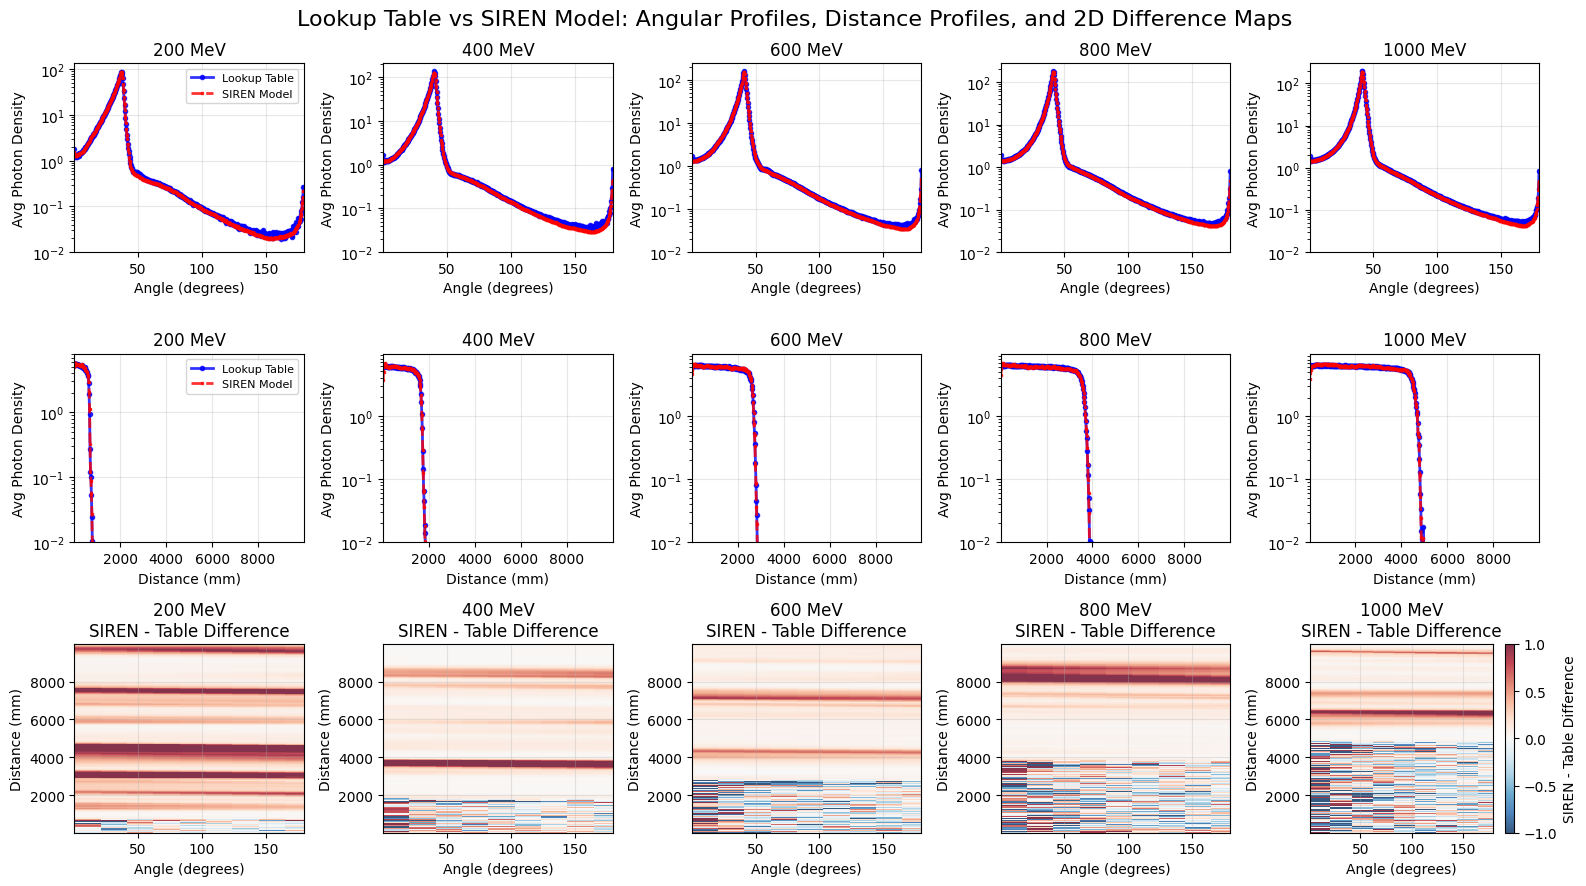

In [14]:
# Create slice comparison plots
fig_slices = analyzer.plot_lookup_table_slices(save_path=output_dir / 'lookup_table_slices.png', figsize=(16,6))
plt.show()

In [ ]:
# Save trained model (now with robust saving built-in)
model_save_dir = output_dir / 'trained_model'
weights_path, metadata_path = trainer.save_trained_model(model_save_dir, 'photonsim_siren')

print(f"✅ Model saved successfully!")
print(f"  Weights: {weights_path}")
print(f"  Metadata: {metadata_path}")

# Display the saved metadata
import json
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"\n📋 Model Metadata:")
print(f"  Energy range: {metadata['dataset_info']['energy_range']} MeV")
print(f"  Angle range: {np.degrees(metadata['dataset_info']['angle_range'])} degrees") 
print(f"  Distance range: {metadata['dataset_info']['distance_range']} mm")
print(f"  Model architecture: {metadata['model_config']['hidden_layers']} layers × {metadata['model_config']['hidden_features']} features")
print(f"  Final training loss: {metadata['training_info']['final_train_loss']:.6f}")
if metadata['training_info']['final_val_loss']:
    print(f"  Final validation loss: {metadata['training_info']['final_val_loss']:.6f}")
print(f"  ✅ Model saved with all metadata and robust parameter handling")

In [16]:
# Import the inference module
sys.path.append(str(project_root / 'siren' / 'training'))
from inference import SIRENPredictor

# Load the saved model
model_base_path = model_save_dir / 'photonsim_siren'
predictor = SIRENPredictor(model_base_path)

print(f"✅ Model loaded successfully!")

# Test single prediction
energy = 500  # MeV
angle = np.radians(45)  # radians 
distance = 2000  # mm

density = predictor.predict(energy, angle, distance)
print(f"\n🔮 Single Prediction Test:")
print(f"  Input: E={energy} MeV, θ={np.degrees(angle):.1f}°, d={distance} mm")
print(f"  Predicted density: {density:.2e} photons/mm²")

# Test batch prediction
test_inputs = np.array([
    [400, np.radians(30), 1500],
    [500, np.radians(45), 2000], 
    [600, np.radians(60), 2500]
])

batch_densities = predictor.predict_batch(test_inputs)
print(f"\n📊 Batch Prediction Test:")
for i, (inp, dens) in enumerate(zip(test_inputs, batch_densities)):
    print(f"  Input {i+1}: E={inp[0]:.0f} MeV, θ={np.degrees(inp[1]):.1f}°, d={inp[2]:.0f} mm → {dens:.2e}")

# Display model info
info = predictor.get_info()
print(f"\n📋 Loaded Model Info:")
print(f"  Energy range: {info['dataset_info']['energy_range']} MeV")
print(f"  Angle range: {np.degrees(info['dataset_info']['angle_range'])} degrees")
print(f"  Distance range: {info['dataset_info']['distance_range']} mm")

INFO:inference:Keys in weights file: ['params_SineLayer_0_Dense_0_bias', 'params_SineLayer_0_Dense_0_kernel', 'params_SineLayer_1_Dense_0_bias', 'params_SineLayer_1_Dense_0_kernel', 'params_SineLayer_2_Dense_0_bias', 'params_SineLayer_2_Dense_0_kernel', 'params_SineLayer_3_Dense_0_bias', 'params_SineLayer_3_Dense_0_kernel', 'params_SineLayer_final_Dense_0_bias', 'params_SineLayer_final_Dense_0_kernel']
INFO:inference:Detected flattened parameter format
INFO:inference:Reconstructed nested parameter structure from flattened format
INFO:inference:Final params structure: FrozenDict({
    params: {
        SineLayer_0: {
            Dense_0: {
                bias: (256,),
                kernel: (3, 256),
            },
        },
        SineLayer_1: {
            Dense_0: {
                bias: (256,),
                kernel: (256, 256),
            },
        },
        SineLayer_2: {
            Dense_0: {
                bias: (256,),
                kernel: (256, 256),
            }

✅ Model loaded successfully!

🔮 Single Prediction Test:
  Input: E=500 MeV, θ=45.0°, d=2000 mm
  Predicted density: 1.57e+00 photons/mm²

📊 Batch Prediction Test:
  Input 1: E=400 MeV, θ=30.0°, d=1500 mm → 4.93e+01
  Input 2: E=500 MeV, θ=45.0°, d=2000 mm → 1.56e+00
  Input 3: E=600 MeV, θ=60.0°, d=2500 mm → 3.45e-01

📋 Loaded Model Info:
  Energy range: [100.0, 1000.0] MeV
  Angle range: [  0.18 179.82] degrees
  Distance range: [10.0, 9990.0] mm


📊 Loaded lookup table with shape: (91, 500, 500)
  Energy range: 100 to 1000 MeV
  Angle range: 0.2 to 179.8 degrees
  Distance range: 10 to 9990 mm
\n🔍 Energy 200 MeV:
  Table range: 0.00e+00 to 6.38e+02
  SIREN range: 2.53e-03 to 4.93e+02
  SIREN/Table ratio: 1.64
\n🔍 Energy 400 MeV:
  Table range: 0.00e+00 to 8.35e+02
  SIREN range: 2.53e-03 to 5.26e+02
  SIREN/Table ratio: 1.14
\n🔍 Energy 600 MeV:
  Table range: 0.00e+00 to 9.16e+02
  SIREN range: 2.63e-03 to 7.08e+02
  SIREN/Table ratio: 1.11
\n🔍 Energy 800 MeV:
  Table range: 0.00e+00 to 9.70e+02
  SIREN range: 2.54e-03 to 7.74e+02
  SIREN/Table ratio: 1.04
\n🔍 Energy 1000 MeV:
  Table range: 0.00e+00 to 9.43e+02
  SIREN range: 2.53e-03 to 7.32e+02
  SIREN/Table ratio: 1.05


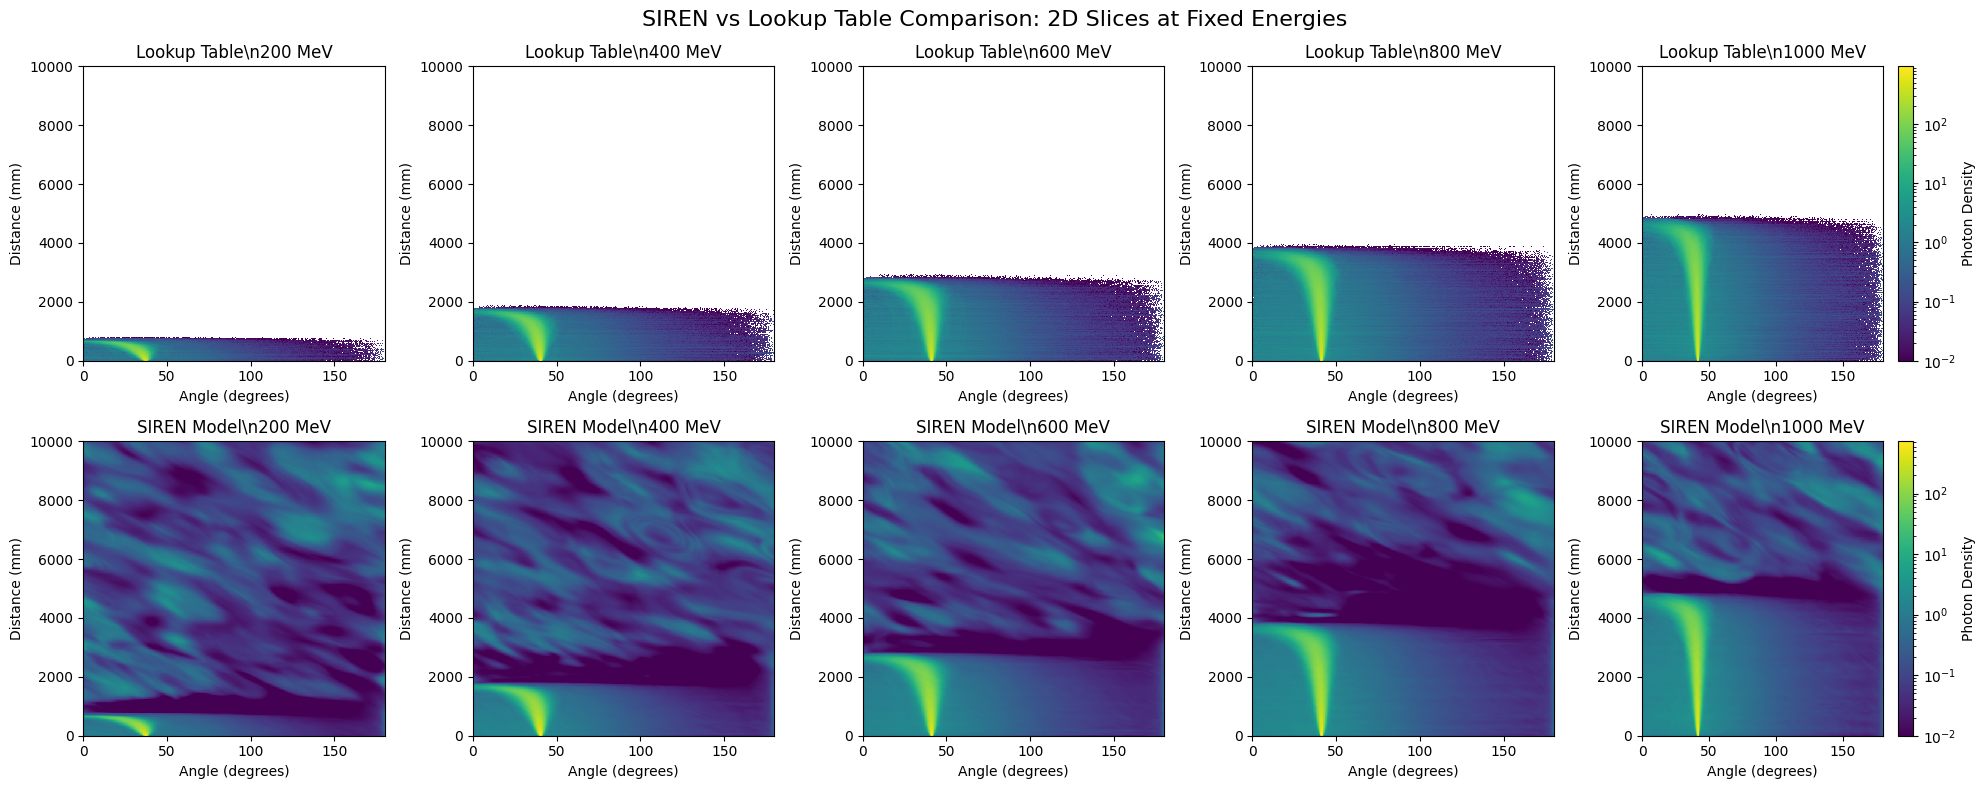

\n✅ Comparison plot saved to: output/photonsim_siren_training/siren_vs_lookup_comparison.png


In [17]:
# Load original lookup table for comparison
import h5py
from matplotlib.colors import LogNorm

# Define energies to compare
energies_to_plot = [200, 400, 600, 800, 1000]  # MeV

# Load the original HDF5 file
h5_path = photonsim_root / 'output' / 'photon_lookup_table.h5'

with h5py.File(h5_path, 'r') as f:
    # Load full density table and coordinates
    density_table = f['data/photon_table_density'][:]  # Shape: (n_energy, n_angle, n_distance)
    energy_centers = f['coordinates/energy_centers'][:]
    angle_centers = f['coordinates/angle_centers'][:]
    distance_centers = f['coordinates/distance_centers'][:]

print(f"📊 Loaded lookup table with shape: {density_table.shape}")
print(f"  Energy range: {energy_centers.min():.0f} to {energy_centers.max():.0f} MeV")
print(f"  Angle range: {np.degrees(angle_centers.min()):.1f} to {np.degrees(angle_centers.max()):.1f} degrees")
print(f"  Distance range: {distance_centers.min():.0f} to {distance_centers.max():.0f} mm")

# Create figure with 2 rows × 5 columns
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('SIREN vs Lookup Table Comparison: 2D Slices at Fixed Energies', fontsize=16)

for i, energy in enumerate(energies_to_plot):
    # Find closest energy index in lookup table
    energy_idx = np.argmin(np.abs(energy_centers - energy))
    actual_energy = energy_centers[energy_idx]
    
    if np.abs(actual_energy - energy) > 100:  # Skip if too far
        axes[0, i].text(0.5, 0.5, f'No data near\\n{energy} MeV', 
                       ha='center', va='center', transform=axes[0, i].transAxes)
        axes[1, i].text(0.5, 0.5, f'No data near\\n{energy} MeV', 
                       ha='center', va='center', transform=axes[1, i].transAxes)
        continue
    
    # Get lookup table slice
    table_slice = density_table[energy_idx, :, :]  # Shape: (n_angle, n_distance)
    
    # Create SIREN prediction for the same grid
    angle_mesh, distance_mesh = np.meshgrid(angle_centers, distance_centers, indexing='ij')
    energy_grid = np.full_like(angle_mesh, actual_energy)
    
    # Stack coordinates for SIREN prediction
    eval_coords = np.stack([
        energy_grid.flatten(),
        angle_mesh.flatten(),
        distance_mesh.flatten()
    ], axis=-1)
    
    # Get SIREN predictions
    siren_predictions = predictor.predict_batch(eval_coords)
    siren_slice = siren_predictions.reshape(angle_mesh.shape)
    
    # Convert angles to degrees for plotting
    angle_mesh_deg = np.degrees(angle_mesh)
    
    # Plot lookup table (top row)
    ax_table = axes[0, i]
    
    # Use log scale for better visualization
    table_slice_plot = np.where(table_slice > 1e-10, table_slice, np.nan)
    im1 = ax_table.pcolormesh(angle_mesh_deg, distance_mesh, table_slice_plot, 
                             cmap='viridis', shading='auto',
                             norm=LogNorm(vmin=1e-2, vmax=table_slice.max()))
    
    ax_table.set_title(f'Lookup Table\\n{actual_energy:.0f} MeV')
    ax_table.set_xlabel('Angle (degrees)')
    ax_table.set_ylabel('Distance (mm)')
    
    if i == 4:  # Add colorbar to last plot
        cbar1 = plt.colorbar(im1, ax=ax_table)
        cbar1.set_label('Photon Density')
    
    # Plot SIREN predictions (bottom row)
    ax_siren = axes[1, i]
    
    siren_slice_plot = np.where(siren_slice > 1e-10, siren_slice, np.nan)
    im2 = ax_siren.pcolormesh(angle_mesh_deg, distance_mesh, siren_slice_plot, 
                             cmap='viridis', shading='auto',
                             norm=LogNorm(vmin=1e-2, vmax=siren_slice.max()))
    
    ax_siren.set_title(f'SIREN Model\\n{actual_energy:.0f} MeV')
    ax_siren.set_xlabel('Angle (degrees)')
    ax_siren.set_ylabel('Distance (mm)')
    
    if i == 4:  # Add colorbar to last plot
        cbar2 = plt.colorbar(im2, ax=ax_siren)
        cbar2.set_label('Photon Density')
    
    # Print comparison stats
    print(f"\\n🔍 Energy {actual_energy:.0f} MeV:")
    print(f"  Table range: {table_slice.min():.2e} to {table_slice.max():.2e}")
    print(f"  SIREN range: {siren_slice.min():.2e} to {siren_slice.max():.2e}")
    print(f"  SIREN/Table ratio: {siren_slice.mean()/table_slice.mean():.2f}")

plt.tight_layout()
plt.savefig(output_dir / 'siren_vs_lookup_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\\n✅ Comparison plot saved to: {output_dir / 'siren_vs_lookup_comparison.png'}")

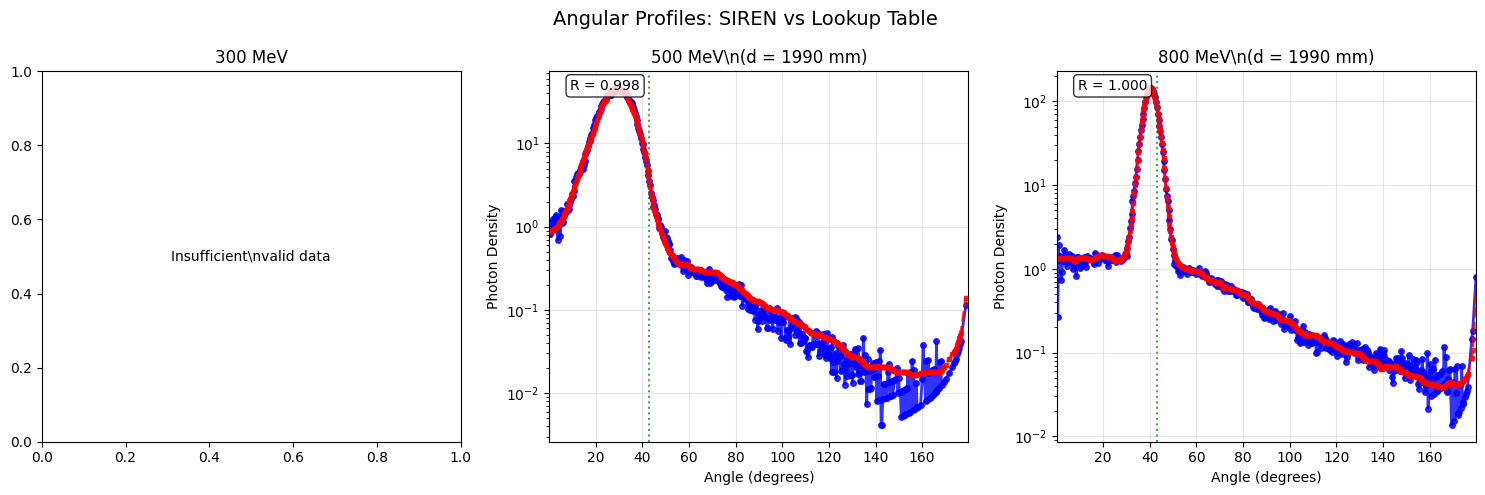

✅ Angular profile comparison saved to: output/photonsim_siren_training/angular_profile_comparison.png


In [18]:
# Create angular profile comparison plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Angular Profiles: SIREN vs Lookup Table', fontsize=14)

energies_for_profiles = [300, 500, 800]
fixed_distance = 2000  # mm

for i, energy in enumerate(energies_for_profiles):
    ax = axes[i]
    
    # Find closest energy in lookup table
    energy_idx = np.argmin(np.abs(energy_centers - energy))
    actual_energy = energy_centers[energy_idx]
    
    if np.abs(actual_energy - energy) > 100:
        ax.text(0.5, 0.5, f'No data near\\n{energy} MeV', 
               ha='center', va='center', transform=ax.transAxes)
        continue
    
    # Find closest distance index
    distance_idx = np.argmin(np.abs(distance_centers - fixed_distance))
    actual_distance = distance_centers[distance_idx]
    
    # Get lookup table angular profile at this energy and distance
    table_profile = density_table[energy_idx, :, distance_idx]
    
    # Create SIREN predictions for same points
    coords_1d = np.array([[actual_energy, angle, actual_distance] for angle in angle_centers])
    siren_profile = predictor.predict_batch(coords_1d)
    
    # Convert angles to degrees for plotting
    angles_deg = np.degrees(angle_centers)
    
    # Plot both profiles
    valid_mask = (table_profile > 1e-10) & (siren_profile > 1e-10)
    
    if np.sum(valid_mask) > 5:
        ax.plot(angles_deg[valid_mask], table_profile[valid_mask], 
               'o-', alpha=0.8, label='Lookup Table', markersize=4, linewidth=2, color='blue')
        ax.plot(angles_deg[valid_mask], siren_profile[valid_mask], 
               's--', alpha=0.8, label='SIREN Model', markersize=3, linewidth=2, color='red')
        
        # Mark Cherenkov angle (approximately 43 degrees for water)
        ax.axvline(43, color='green', linestyle=':', alpha=0.7, label='Cherenkov angle')
        
        ax.set_xlabel('Angle (degrees)')
        ax.set_ylabel('Photon Density')
        ax.set_title(f'{actual_energy:.0f} MeV\\n(d = {actual_distance:.0f} mm)')
        ax.set_yscale('log')
        ax.set_xlim(angles_deg.min(), angles_deg.max())
        ax.grid(True, alpha=0.3)
        
        if i == 0:  # Show legend only on first plot
            ax.legend()
        
        # Calculate and display correlation
        from scipy.stats import pearsonr
        corr, _ = pearsonr(table_profile[valid_mask], siren_profile[valid_mask])
        ax.text(0.05, 0.95, f'R = {corr:.3f}', transform=ax.transAxes,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax.text(0.5, 0.5, 'Insufficient\\nvalid data', ha='center', va='center', 
               transform=ax.transAxes)
        ax.set_title(f'{energy} MeV')

plt.tight_layout()
plt.savefig(output_dir / 'angular_profile_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Angular profile comparison saved to: {output_dir / 'angular_profile_comparison.png'}")